In [ ]:
!pip install --upgrade pip
!pip install "numpy==1.26.4" "scipy==1.13.1" "scikit-learn==1.5.1" \
             "tensorflow==2.15.0" "keras==2.15.0" --quiet

import os
os._exit(0)  

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.3 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
s3fs 2025.3.0 requires fsspec==2025.3.0.*, but you have fsspec 2025.10.0 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 4.25.8 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
cesium 0.12.4 requires

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import cv2, os
from sklearn.model_selection import train_test_split

2025-11-13 10:26:43.958077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-13 10:26:43.958139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-13 10:26:43.959790: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_DIR = "/kaggle/input/segmention/imiges segmention"


In [3]:
IMAGE_TRAIN = os.path.join(BASE_DIR, "images/train")
IMAGE_VAL = os.path.join(BASE_DIR, "images/val")
IMAGE_TEST = os.path.join(BASE_DIR, "images/test")

MASK_TRAIN = os.path.join(BASE_DIR, "ground_truth/train")
MASK_VAL = os.path.join(BASE_DIR, "ground_truth/val")
MASK_TEST = os.path.join(BASE_DIR, "ground_truth/test")

IMG_HEIGHT, IMG_WIDTH = 128, 128

In [9]:
from scipy.io import loadmat
import glob

def load_images_with_mat_masks(img_dir, mask_dir, img_height, img_width):
    X, Y = [], []
    img_files = glob.glob(os.path.join(img_dir, "*.jpg")) + glob.glob(os.path.join(img_dir, "*.png"))
    mask_files = glob.glob(os.path.join(mask_dir, "*.mat"))
    
    print(f"Found {len(img_files)} images, {len(mask_files)} mask files")

    for img_path in img_files:
        img_name = os.path.basename(img_path).split('.')[0]

        # try to find .mat mask with similar name
        possible_mask = os.path.join(mask_dir, f"{img_name}.mat")
        if not os.path.exists(possible_mask):
            continue
        
        try:
            mat = loadmat(possible_mask)
            # Many Berkeley Segmentation datasets store it like this:
            if "groundTruth" in mat:
                mask_data = mat["groundTruth"][0][0][0][0][1]  # first segmentation
            elif "segmentation" in mat:
                mask_data = mat["segmentation"]
            else:
                print(f"⚠️ Unknown mask structure for {img_name}.mat")
                continue

            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_width, img_height))
            mask = cv2.resize(mask_data.astype(np.float32), (img_width, img_height))
            
            img = img / 255.0
            mask = np.expand_dims(mask / mask.max(), axis=-1)  # normalize
            
            X.append(img)
            Y.append(mask)
        except Exception as e:
            print(f"⚠️ Error reading {img_name}.mat:", e)
            continue

    print(f"✅ Loaded {len(X)} image-mask pairs from {img_dir}")
    return np.array(X), np.array(Y)

# Load dataset
X_train, Y_train = load_images_with_mat_masks(IMAGE_TRAIN, MASK_TRAIN, IMG_HEIGHT, IMG_WIDTH)
X_val, Y_val     = load_images_with_mat_masks(IMAGE_VAL, MASK_VAL, IMG_HEIGHT, IMG_WIDTH)
X_test, Y_test   = load_images_with_mat_masks(IMAGE_TEST, MASK_TEST, IMG_HEIGHT, IMG_WIDTH)

print("Train:", X_train.shape, Y_train.shape)
print("Val:", X_val.shape, Y_val.shape)
print("Test:", X_test.shape, Y_test.shape)


Found 200 images, 200 mask files
✅ Loaded 200 image-mask pairs from /kaggle/input/segmention/imiges segmention/images/train
Found 100 images, 100 mask files
✅ Loaded 100 image-mask pairs from /kaggle/input/segmention/imiges segmention/images/val
Found 200 images, 200 mask files
✅ Loaded 200 image-mask pairs from /kaggle/input/segmention/imiges segmention/images/test
Train: (200, 128, 128, 3) (200, 128, 128, 1)
Val: (100, 128, 128, 3) (100, 128, 128, 1)
Test: (200, 128, 128, 3) (200, 128, 128, 1)


In [10]:
from tensorflow.keras import layers, models

def unet_model(input_size=(128,128,3)):
    inputs = layers.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)
    
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)
    
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)
    
    # Bottleneck
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c4)
    
    # Decoder
    u5 = layers.UpSampling2D((2,2))(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c5)
    
    u6 = layers.UpSampling2D((2,2))(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c6)
    
    u7 = layers.UpSampling2D((2,2))(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c7)
    
    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c7)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Build model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [11]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=8,
    epochs=30
)


Epoch 1/30
25/25 [==============================] - 17s 566ms/step - loss: 0.2133 - accuracy: 0.9332 - val_loss: 0.1009 - val_accuracy: 0.9625
Epoch 2/30
25/25 [==============================] - 14s 547ms/step - loss: 0.0898 - accuracy: 0.9623 - val_loss: 0.0853 - val_accuracy: 0.9625
Epoch 3/30
25/25 [==============================] - 13s 541ms/step - loss: 0.0854 - accuracy: 0.9623 - val_loss: 0.0836 - val_accuracy: 0.9625
Epoch 4/30
25/25 [==============================] - 14s 548ms/step - loss: 0.0830 - accuracy: 0.9623 - val_loss: 0.0823 - val_accuracy: 0.9625
Epoch 5/30
25/25 [==============================] - 13s 536ms/step - loss: 0.0824 - accuracy: 0.9623 - val_loss: 0.0820 - val_accuracy: 0.9625
Epoch 6/30
25/25 [==============================] - 14s 550ms/step - loss: 0.0814 - accuracy: 0.9623 - val_loss: 0.0826 - val_accuracy: 0.9625
Epoch 7/30
25/25 [==============================] - 14s 542ms/step - loss: 0.0819 - accuracy: 0.9623 - val_loss: 0.0811 - val_accuracy: 0.9625

In [12]:
model.save("/kaggle/working/unet_segmentation_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 168ms/step


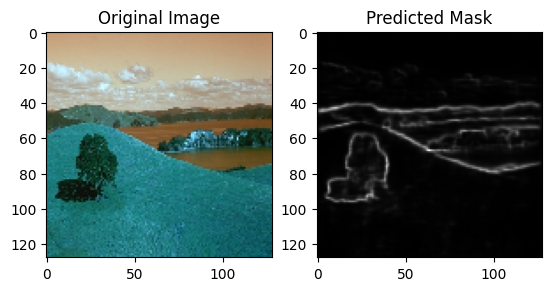

In [13]:
import matplotlib.pyplot as plt

pred_mask = model.predict(np.expand_dims(X_test[0], axis=0))[0]
plt.subplot(1,2,1)
plt.imshow(X_test[0])
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(pred_mask[:,:,0], cmap='gray')
plt.title("Predicted Mask")
plt.show()